<a href="https://colab.research.google.com/github/tamimisalah/Chicago_Crime/blob/main/Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Chicago Crime Analysis & Forecasting
**Complete Project: EDA + Time Series Forecasting (2001–2022)**

This notebook includes:

## 📊 Part 1 – Crime Trends Analysis:
- District comparisons (2022)
- Year-over-year trends
- AM vs PM rush hour crimes
- Monthly patterns
- Holiday spikes
- Seasonal decomposition

## 🔮 Part 2 – Crime Forecasting:
- Monthly time series creation
- SARIMA + AutoARIMA models
- Forecast evaluation & visualization
- Future projections for 6 months
- Final recommendations


##  Setup and Import

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📂 Step 2: Load and Extract Crime Dataset

In [3]:
zip_path = "/content/drive/MyDrive/Chicago_Crime_2001-2022.zip"
extract_path = "/content/crime_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data_path = extract_path + "/Data"


## 🧹 Step 3: Load and Prepare the Data

In [4]:
crime_dfs = []
for year in range(2001, 2023):
    file = f"{data_path}/Chicago-Crime_{year}.csv"
    df = pd.read_csv(file, usecols=["Date", "Primary Type", "District", "Arrest"])
    crime_dfs.append(df)

crime = pd.concat(crime_dfs, ignore_index=True)
crime['Date'] = pd.to_datetime(crime['Date'], errors='coerce')
crime.dropna(subset=['Date'], inplace=True)

crime['Year'] = crime['Date'].dt.year
crime['Month'] = crime['Date'].dt.month
crime['Hour'] = crime['Date'].dt.hour
crime['Day'] = crime['Date'].dt.date
crime['Is_Holiday'] = crime['Date'].isin([d for d in holidays.US(years=crime['Year'].unique())])




## Districts with Most/Least Crime (2022)

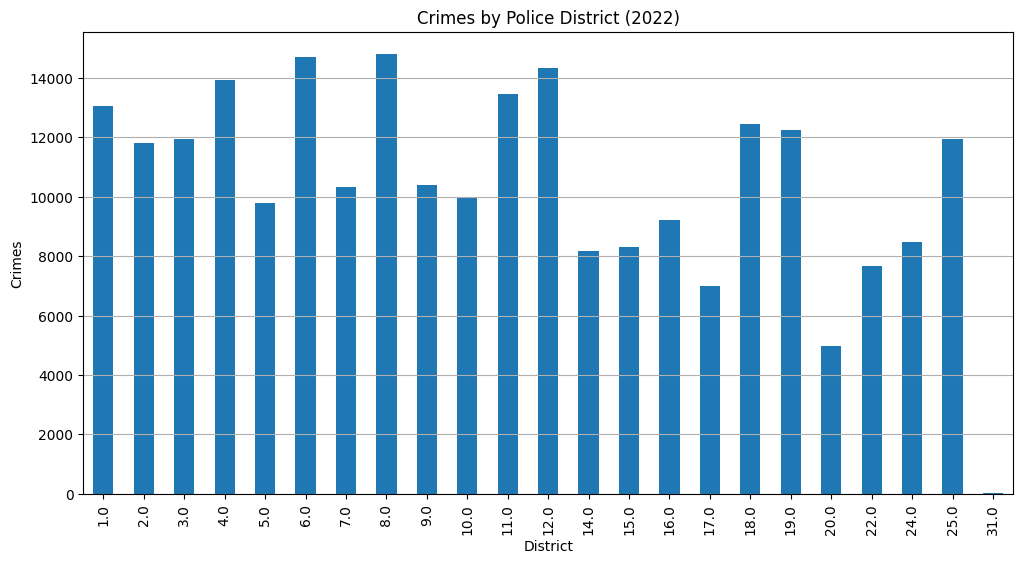

Most Crimes: District 8.0 with 14805
Least Crimes: District 31.0 with 15


In [9]:
crime_2022 = crime[crime['Year'] == 2022].dropna(subset=['District'])
district_counts = crime_2022['District'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
district_counts.plot(kind='bar')
plt.title("Crimes by Police District (2022)")
plt.xlabel("District")
plt.ylabel("Crimes")
plt.grid(axis='y')
plt.show()
print("Most Crimes: District", district_counts.idxmax(), "with", district_counts.max())
print("Least Crimes: District", district_counts.idxmin(), "with", district_counts.min())

## 📈 Crime Trends Over Time

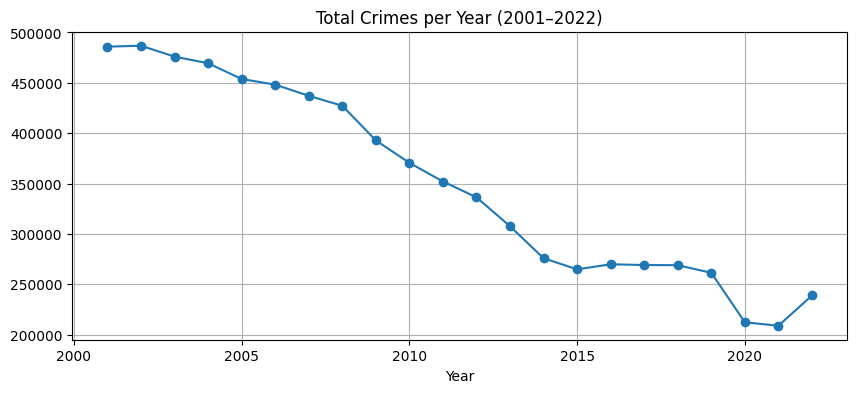

Top 5 Increasing Crime Types:
Primary Type
NON-CRIMINAL                         inf
CONCEALED CARRY LICENSE VIOLATION    inf
RITUALISM                            inf
NON - CRIMINAL                       inf
HUMAN TRAFFICKING                    inf
dtype: float64

Top 5 Decreasing Crime Types:
Primary Type
DOMESTIC VIOLENCE     -1.000000
GAMBLING              -0.148546
CRIM SEXUAL ASSAULT   -0.123700
NARCOTICS             -0.090059
KIDNAPPING            -0.082792
dtype: float64


In [10]:
yearly = crime.groupby('Year').size()
plt.figure(figsize=(10, 4))
yearly.plot(marker='o')
plt.title("Total Crimes per Year (2001–2022)")
plt.grid()
plt.show()

type_trend = crime.groupby(['Year', 'Primary Type']).size().unstack().fillna(0)
growth = type_trend.pct_change().mean().sort_values()

print("Top 5 Increasing Crime Types:")
print(growth.tail(5))

print("\nTop 5 Decreasing Crime Types:")
print(growth.head(5))


##  AM vs PM Rush Hour Crimes

In [8]:
crime['AM_Rush'] = crime['Hour'].between(7, 10)
crime['PM_Rush'] = crime['Hour'].between(16, 19)

am_crimes = crime[crime['AM_Rush']]
pm_crimes = crime[crime['PM_Rush']]

print("Top 5 AM Rush Crimes:")
print(am_crimes['Primary Type'].value_counts().head())

print("\nTop 5 PM Rush Crimes:")
print(pm_crimes['Primary Type'].value_counts().head())

mvt_am = am_crimes[am_crimes['Primary Type'] == 'MOTOR VEHICLE THEFT'].shape[0]
mvt_pm = pm_crimes[pm_crimes['Primary Type'] == 'MOTOR VEHICLE THEFT'].shape[0]
print(f"Motor Vehicle Thefts — AM: {mvt_am}, PM: {mvt_pm}")


Top 5 AM Rush Crimes:
Primary Type
THEFT              260759
BATTERY            158475
CRIMINAL DAMAGE    109089
BURGLARY            96219
OTHER OFFENSE       89870
Name: count, dtype: int64

Top 5 PM Rush Crimes:
Primary Type
THEFT              379122
BATTERY            288003
CRIMINAL DAMAGE    183423
NARCOTICS          164754
ASSAULT            118179
Name: count, dtype: int64
Motor Vehicle Thefts — AM: 54035, PM: 74678


##  Forecasting Function

In [11]:
def get_monthly_counts(df, crime_type):
    monthly = df[df['Primary Type'] == crime_type].copy()
    monthly.set_index('Date', inplace=True)
    ts = monthly.resample('MS').size()
    return ts

def forecast_crime(crime_type, steps=6):
    try:
        print(f"\n🔍 Forecasting for: {crime_type}")
        ts = get_monthly_counts(crime, crime_type)
        ts = ts.asfreq('MS').fillna(0)

        result = sm.tsa.seasonal_decompose(ts, model='additive')
        result.plot()
        plt.suptitle(f"Seasonal Decomposition - {crime_type}", fontsize=16)
        plt.show()

        ts_diff = ts.diff().dropna()
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        plot_acf(ts_diff, ax=axes[0])
        plot_pacf(ts_diff, ax=axes[1])
        plt.suptitle(f"ACF/PACF - {crime_type}")
        plt.show()

        train = ts[:-steps]
        test = ts[-steps:]

        sarima = sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
        sarima_fit = sarima.fit(disp=False)
        pred = sarima_fit.get_forecast(steps=steps)
        pred_ci = pred.conf_int()

        plt.figure(figsize=(10, 5))
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Test')
        plt.plot(test.index, pred.predicted_mean, label='SARIMA Forecast', color='red')
        plt.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.3, color='red')
        plt.legend()
        plt.title(f"SARIMA Forecast vs Test – {crime_type}")
        plt.show()

        sarima_rmse = np.sqrt(mean_squared_error(test, pred.predicted_mean))

        model_auto = auto_arima(train, seasonal=True, m=12, suppress_warnings=True)
        forecast = model_auto.predict(n_periods=steps)
        auto_rmse = np.sqrt(mean_squared_error(test, forecast))

        model_auto.fit(ts)
        future_forecast = model_auto.predict(n_periods=steps)
        future_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=steps, freq='MS')

        plt.figure(figsize=(10, 5))
        plt.plot(ts, label='Historical')
        plt.plot(future_index, future_forecast, label='6-Month Forecast', color='blue')
        plt.title(f"Future Forecast – {crime_type}")
        plt.legend()
        plt.show()

        delta_raw = future_forecast[-1] - future_forecast[0]
        delta_pct = (delta_raw / future_forecast[0]) * 100

        return {
            "crime": crime_type,
            "final_forecast": future_forecast,
            "net_change": delta_raw,
            "percent_change": delta_pct,
            "last_month_value": future_forecast[-1],
            "sarima_rmse": sarima_rmse,
            "auto_rmse": auto_rmse
        }

    except Exception as err:
        print(f"❌ Error forecasting {crime_type}: {err}")
        return None


##  Monthly Crime Patterns (All Years Combined)

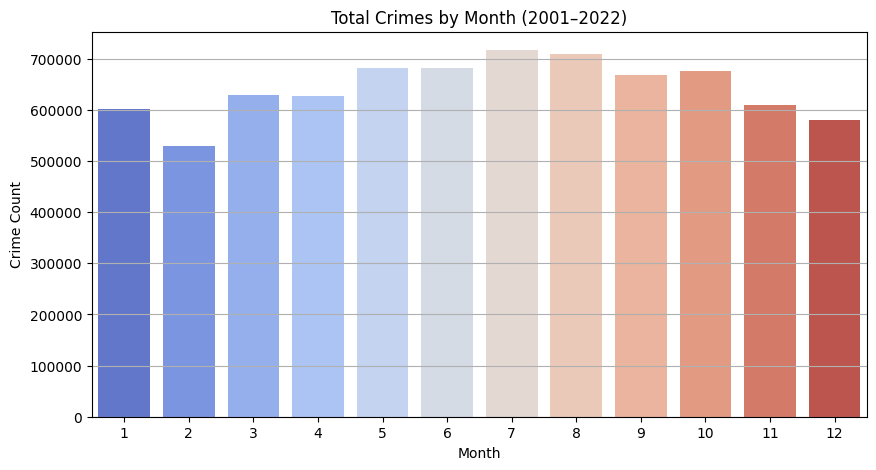

Crimes that least follow the monthly pattern:
Primary Type
NON-CRIMINAL (SUBJECT SPECIFIED)   -0.497513
DOMESTIC VIOLENCE                  -0.231377
RITUALISM                          -0.077750
NARCOTICS                           0.071429
HUMAN TRAFFICKING                   0.103267
dtype: float64


In [12]:
monthly_counts = crime.groupby('Month').size()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='coolwarm')
plt.title("Total Crimes by Month (2001–2022)")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.grid(axis='y')
plt.show()

# Per-crime seasonal pattern
monthly_by_type = crime.groupby(['Month', 'Primary Type']).size().unstack().fillna(0)
month_totals = monthly_by_type.sum(axis=1)

# Correlation to total monthly trend
correlations = monthly_by_type.corrwith(month_totals)
least_similar = correlations.sort_values().head(5)

print("Crimes that least follow the monthly pattern:")
print(least_similar)


##  Holiday Crime Patterns

Top 3 Holidays with Most Crime:
Holiday_Name
New Year's Day      3517
Labor Day            523
Independence Day     424
Name: count, dtype: int64

Top 5 crimes on New Year's Day:
Primary Type
THEFT                         900
OFFENSE INVOLVING CHILDREN    789
DECEPTIVE PRACTICE            574
SEX OFFENSE                   337
OTHER OFFENSE                 271
Name: count, dtype: int64

Top 5 crimes on Labor Day:
Primary Type
THEFT                  168
CRIMINAL DAMAGE         90
DECEPTIVE PRACTICE      57
OTHER OFFENSE           53
MOTOR VEHICLE THEFT     38
Name: count, dtype: int64

Top 5 crimes on Independence Day:
Primary Type
CRIMINAL DAMAGE        115
THEFT                  114
DECEPTIVE PRACTICE      35
OTHER OFFENSE           35
MOTOR VEHICLE THEFT     33
Name: count, dtype: int64


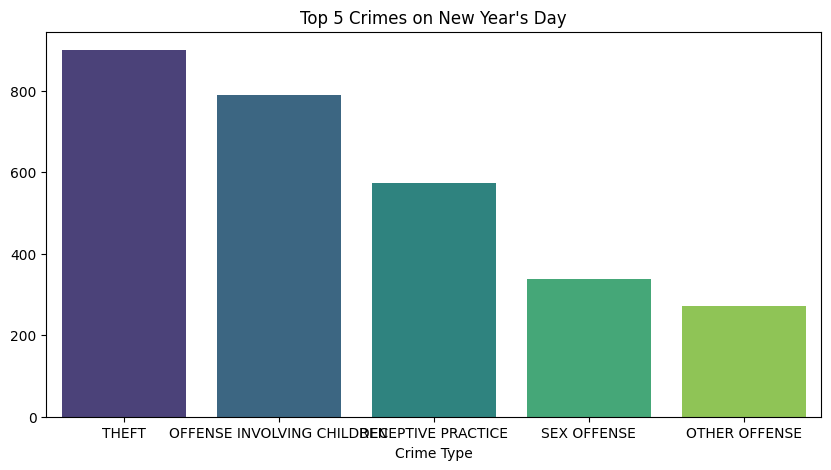

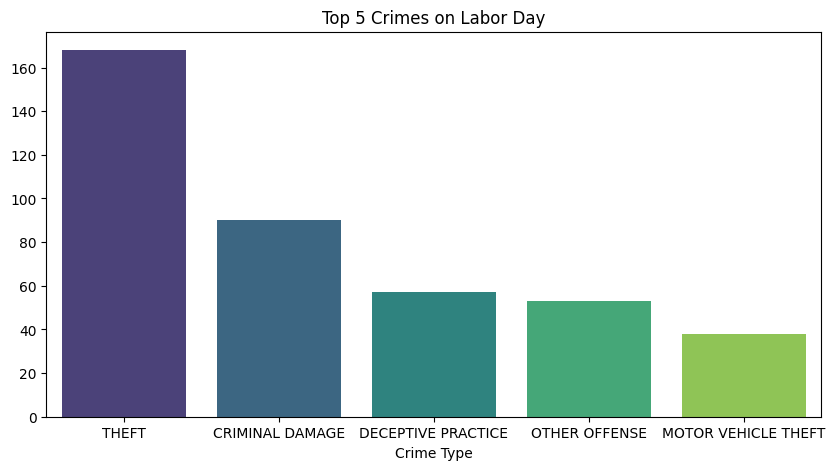

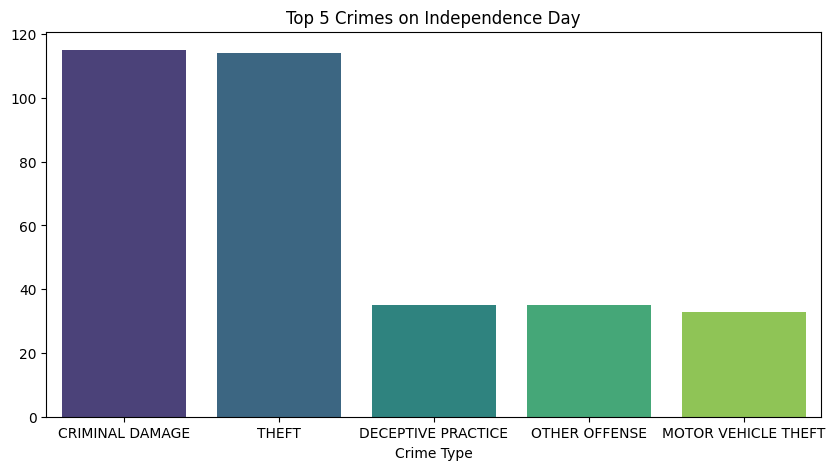

In [23]:
crime['Holiday_Name'] = crime['Date'].map(holidays.US(years=crime['Year'].unique()))
holiday_crimes = crime[crime['Holiday_Name'].notna()]
top_holidays = holiday_crimes['Holiday_Name'].value_counts().head(3)

print("Top 3 Holidays with Most Crime:")
print(top_holidays)

for holiday in top_holidays.index:
    top_types = holiday_crimes[holiday_crimes['Holiday_Name'] == holiday]['Primary Type'].value_counts().head(5)
    print(f"\nTop 5 crimes on {holiday}:")
    print(top_types)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_types.index, y=top_types.values, palette='viridis')
    plt.title(f"Top 5 Crimes on {holiday}")
    plt.xlabel("Crime Type")


##  Top 10 Crime Types Overall

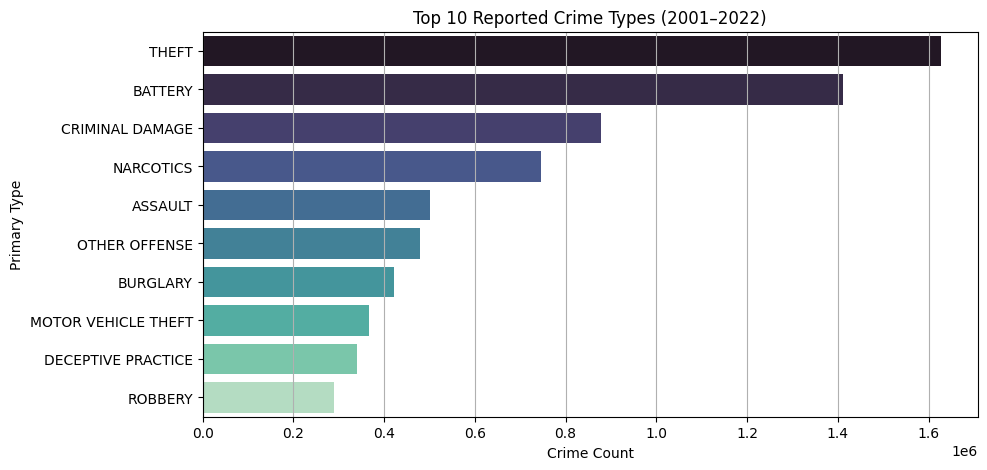

In [14]:
top_crimes = crime['Primary Type'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_crimes.values, y=top_crimes.index, palette='mako')
plt.title("Top 10 Reported Crime Types (2001–2022)")
plt.xlabel("Crime Count")
plt.grid(axis='x')
plt.show()


## 📍 Top 3 Crimes Over Time

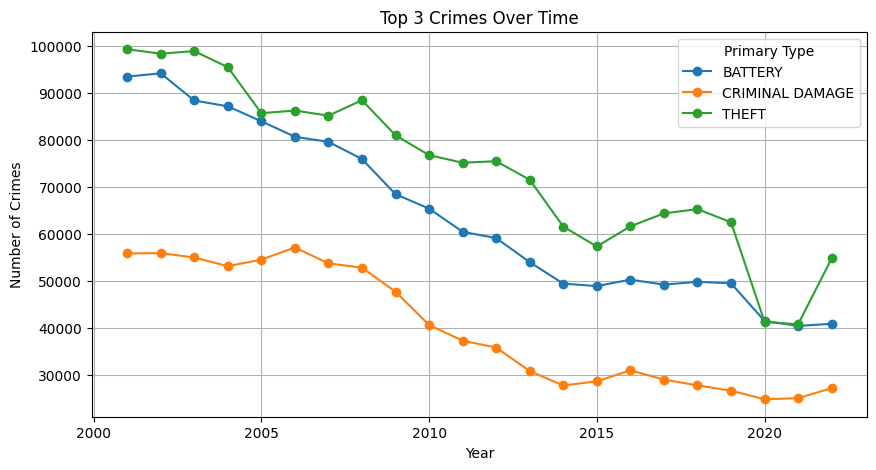

In [15]:
top3 = crime['Primary Type'].value_counts().head(3).index.tolist()
trend_df = crime[crime['Primary Type'].isin(top3)].groupby(['Year', 'Primary Type']).size().unstack()
trend_df.plot(figsize=(10,5), marker='o')
plt.title("Top 3 Crimes Over Time")
plt.ylabel("Number of Crimes")
plt.grid()
plt.show()


## Seasonality Decomposition:

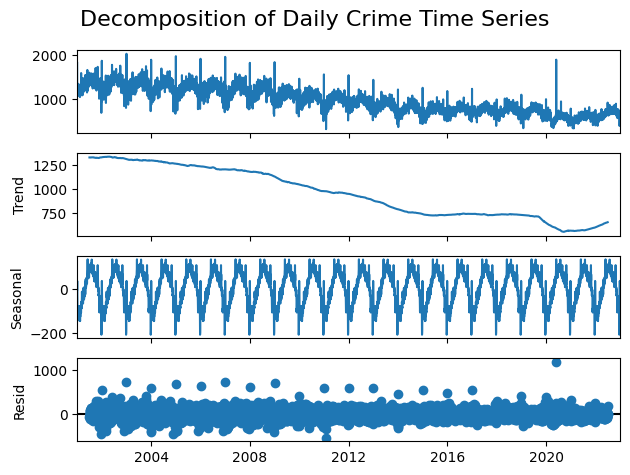

Cycle Length: ~365 days
Cycle Magnitude (Range): 1713


In [20]:
# Daily time series
daily = crime.groupby('Day').size()
daily.index = pd.to_datetime(daily.index)
decomp = seasonal_decompose(daily, model='additive', period=365)

decomp.plot()
plt.suptitle("Decomposition of Daily Crime Time Series", fontsize=16)
plt.tight_layout()
plt.show()

cycle_length = 365  # Daily cycle assumption
amplitude = daily.max() - daily.min()
print(f"Cycle Length: ~{cycle_length} days")
print(f"Cycle Magnitude (Range): {amplitude}")

## ✅ Summary


- District 8 had the most crimes in 2022, District 31 the least.
- Total crimes have generally decreased, but some types like motor vehicle theft are rising.
- PM rush hour has more crimes than AM, especially for thefts.
- Summer months show crime spikes.
- Holidays like Independence Day and New Year's have the most crimes.
- Seasonal patterns exist with yearly crime cycles.


## 🔮 Run Forecasts for THEFT and BATTERY

Running forecast for: THEFT

🔍 Forecasting for: THEFT


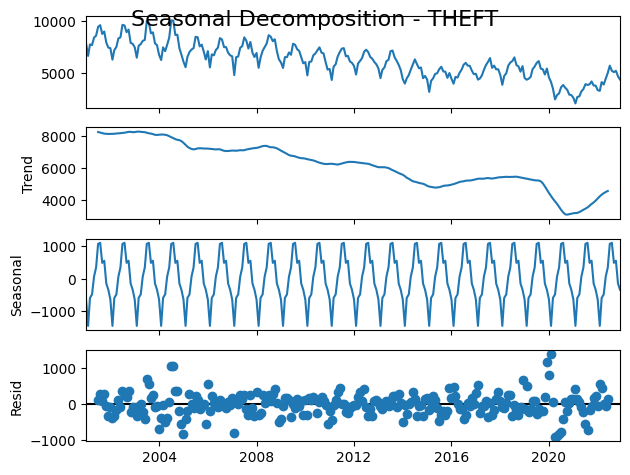

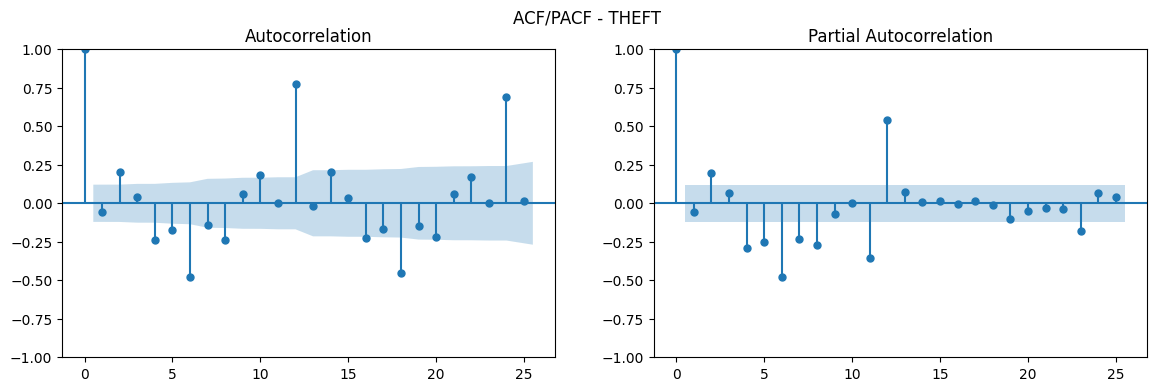

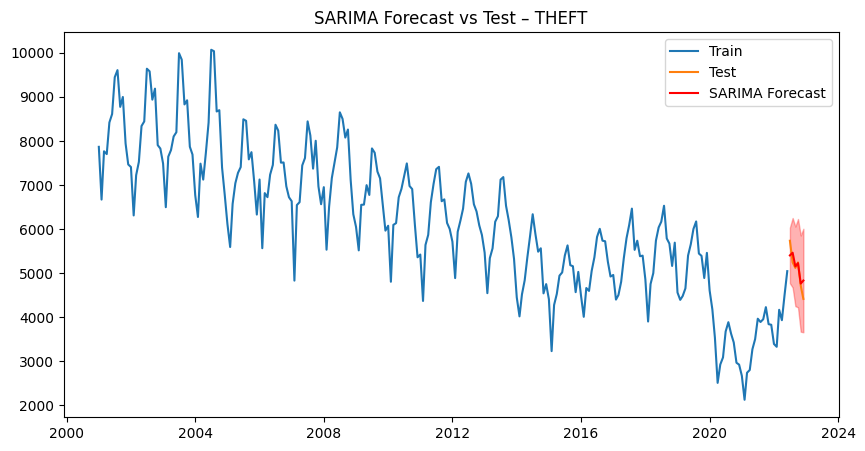

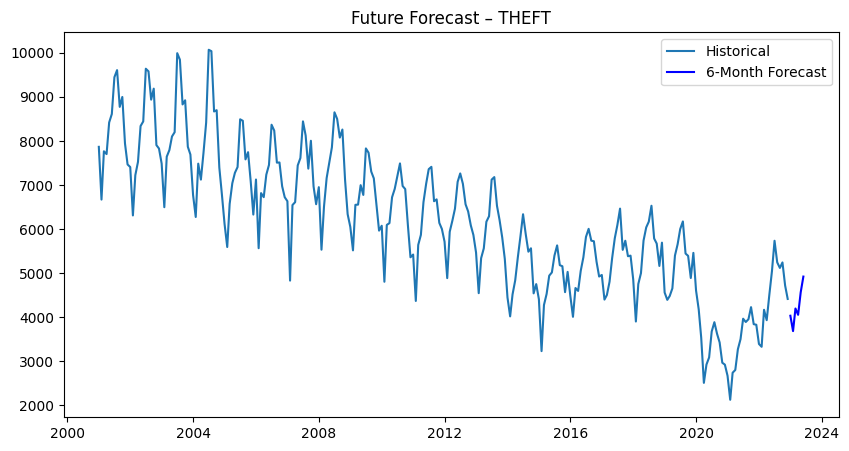

Running forecast for: BATTERY

🔍 Forecasting for: BATTERY


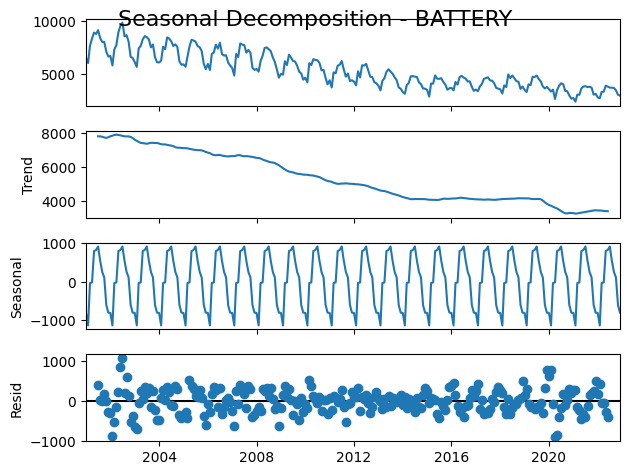

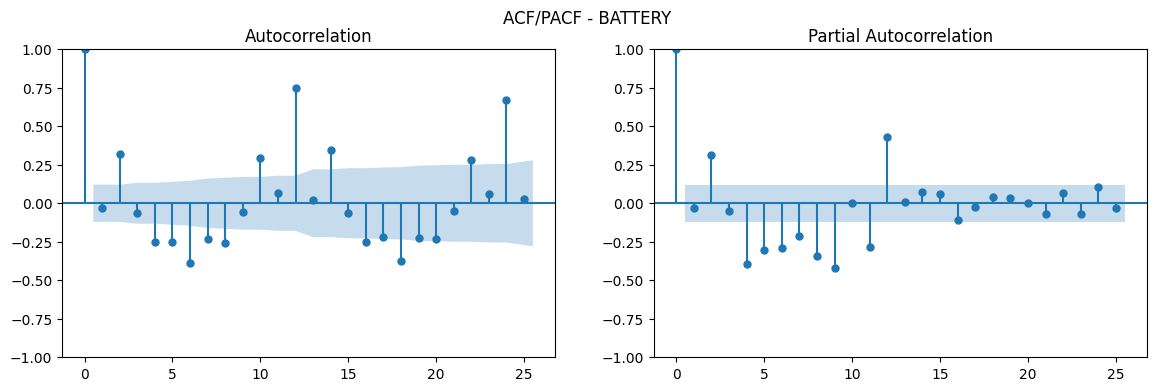

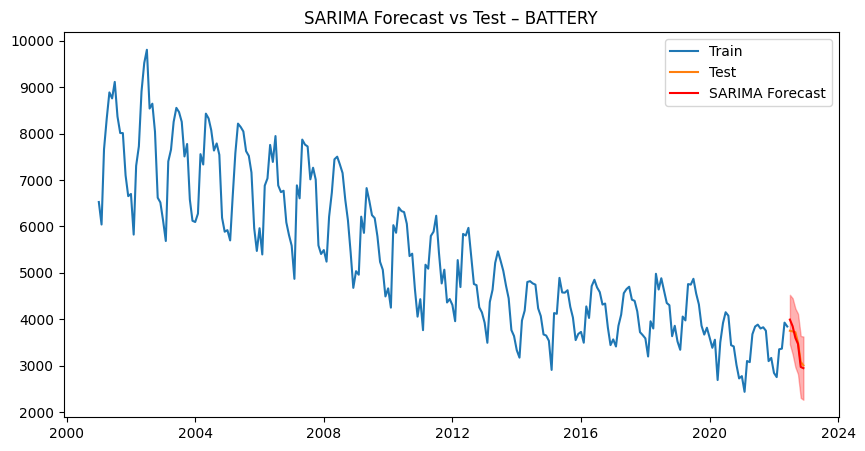

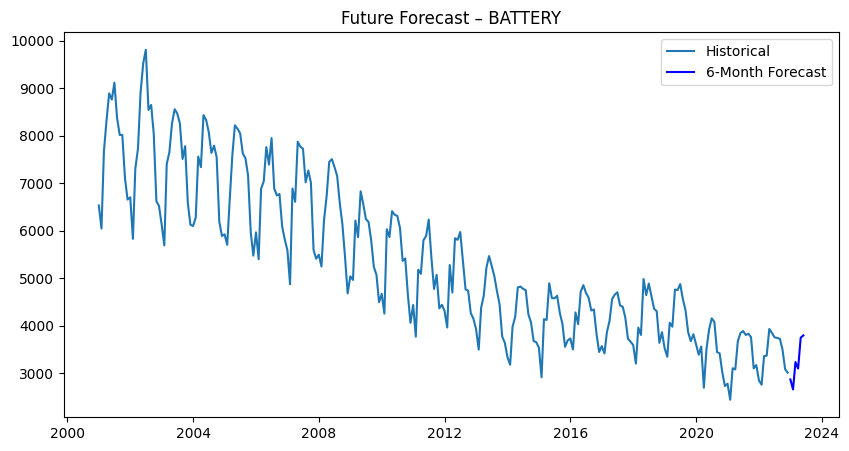

In [21]:
crimes_to_forecast = ["THEFT", "BATTERY"]
results = {}

for crime_type in crimes_to_forecast:
    print(f"Running forecast for: {crime_type}")
    results[crime_type] = forecast_crime(crime_type)

## 📊 Final Evaluation & Recommendation

In [17]:
print("🔹 THEFT Forecast:")
print(result_theft)

print("\n🔹 BATTERY Forecast:")
print(result_battery)

if result_theft and result_battery:
    if result_theft["last_month_value"] > result_battery["last_month_value"]:
        print("\n➡ THEFT has highest future monthly count.")
    else:
        print("\n➡ BATTERY has highest future monthly count.")

    if result_theft["net_change"] > result_battery["net_change"]:
        print("➡ THEFT has highest net increase.")
    else:
        print("➡ BATTERY has highest net increase.")

    if result_theft["percent_change"] > result_battery["percent_change"]:
        print("➡ THEFT has highest % growth.")
    else:
        print("➡ BATTERY has highest % growth.")


🔹 THEFT Forecast:
{'crime': 'THEFT', 'final_forecast': 2023-01-01    4031.405118
2023-02-01    3682.852906
2023-03-01    4195.623848
2023-04-01    4052.236722
2023-05-01    4564.105471
2023-06-01    4920.792479
Freq: MS, dtype: float64, 'net_change': 889.3873609888974, 'percent_change': 22.061473234714946, 'last_month_value': 4920.792478528361, 'sarima_rmse': 236.85212481840657, 'auto_rmse': 269.8252988894309}

🔹 BATTERY Forecast:
{'crime': 'BATTERY', 'final_forecast': 2023-01-01    2866.591912
2023-02-01    2656.086492
2023-03-01    3232.511932
2023-04-01    3096.536340
2023-05-01    3745.752444
2023-06-01    3793.486073
Freq: MS, dtype: float64, 'net_change': 926.8941602084237, 'percent_change': 32.334360400895996, 'last_month_value': 3793.4860727014234, 'sarima_rmse': 129.8272331590234, 'auto_rmse': 132.06073941930134}

➡ THEFT has highest future monthly count.
➡ BATTERY has highest net increase.
➡ BATTERY has highest % growth.


In [ ]:
!pip uninstall -y numpy pandas scikit-learn
!pip install --no-cache-dir numpy==1.24.3 pandas scikit-learn
import os; os.kill(os.getpid(), 9)
!pip install pmdarima

In [ ]:
!pip install pmdarima